In [113]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.optimizers import RMSprop # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.layers import Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical # type: ignore

In [114]:

data_path = '../data/district_classification_dataset_v5.csv'
df = pd.read_csv(data_path)
df.head()

,students_passed,num_teachers,total_students,Total_budget,dropout_rate,avg_class_size,school_distance,district_label
0,354,77,757,10531,0.22,9.83,1,Kicukiro
1,611,42,2630,9088,0.15,62.62,3,Kicukiro
2,471,16,2295,18900,0.17,143.44,6,Kicukiro
3,762,21,1995,8804,0.05,95.00,5,Kicukiro
4,927,93,1440,9201,0.27,15.48,7,Kicukiro


In [115]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   students_passed  9990 non-null   int64  
 1   num_teachers     9990 non-null   int64  
 2   total_students   9990 non-null   int64  
 3   Total_budget     9990 non-null   int64  
 4   dropout_rate     9990 non-null   float64
 5   avg_class_size   9990 non-null   float64
 6   school_distance  9990 non-null   int64  
 7   district_label   9990 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 624.5+ KB


,students_passed,num_teachers,total_students,Total_budget,dropout_rate,avg_class_size,school_distance
count,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,598.003804,54.475375,1743.749249,12438.534034,0.175727,45.565749,5.002402
std,231.232501,25.990972,726.029168,4329.508813,0.072861,41.202972,2.593336
min,200.000000,10.000000,500.000000,5002.000000,0.050000,5.120000,1.000000
25%,396.000000,32.000000,1107.000000,8627.250000,0.110000,19.842500,3.000000
50%,596.000000,54.000000,1735.000000,12453.500000,0.180000,31.850000,5.000000
75%,800.000000,77.000000,2381.000000,16184.750000,0.240000,55.407500,7.000000
max,999.000000,99.000000,2999.000000,19999.000000,0.300000,298.900000,9.000000


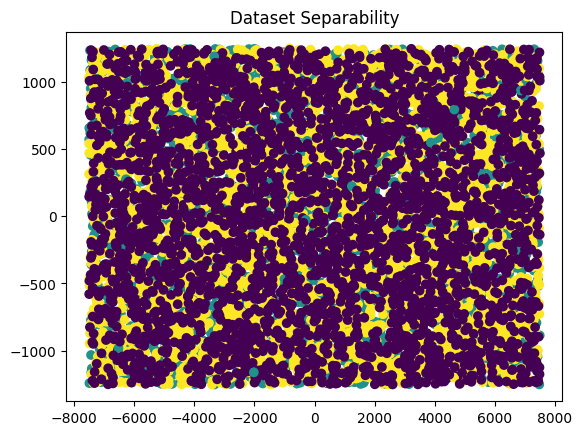

In [116]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis")
plt.title("Dataset Separability")
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_5304\4034844042.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='district_label', data=df, palette='viridis')


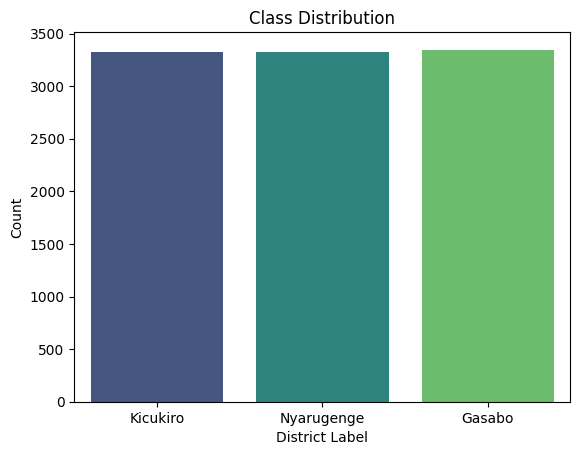

In [117]:
sns.countplot(x='district_label', data=df, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('District Label')
plt.ylabel('Count')
plt.show()


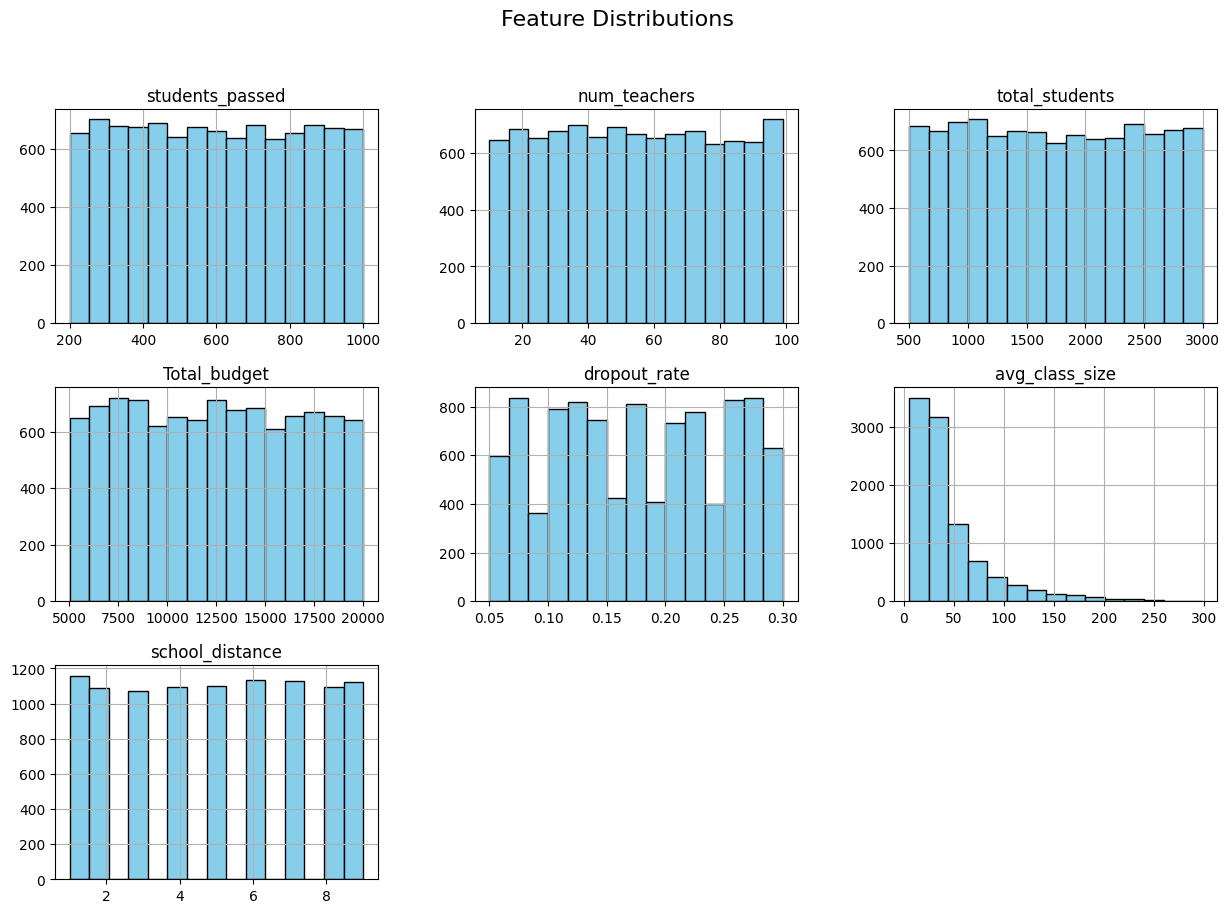

In [118]:
df.iloc[:, :-1].hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()

In [119]:
X_numeric = df[['students_passed', 'num_teachers', 'total_students', 'Total_budget', 
                'dropout_rate', 'avg_class_size', 'school_distance']].values

district_mapping = {'Nyarugenge': 0, 'Kicukiro': 1, 'Gasabo': 2}
df['target'] = df['district_label'].map(district_mapping)

y = df['target'].values

X = X_numeric 

print(X.shape, y.shape) 


(9990, 7) (9990,)


In [120]:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

y_train_encoded = to_categorical(y_train, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}")


Training set size: (7992, 7), Validation set size: (999, 7), Test set size: (999, 7)


In [121]:

scaler = StandardScaler()
X_train[:, :4] = scaler.fit_transform(X_train[:, :4])
X_val[:, :4] = scaler.transform(X_val[:, :4])
X_test[:, :4] = scaler.transform(X_test[:, :4])


In [122]:
model = Sequential()
input_shape = X_train.shape[1]
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,))),
model.add(Dropout(0.3)),
model.add(layers.Dense(32, activation='relu')),
model.add(Dropout(0.3)),
model.add(layers.Dense(16, activation='relu')),
model.add(layers.Dense(3, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3448 - loss: 1.9630 - val_accuracy: 0.3413 - val_loss: 1.0987
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3257 - loss: 1.1579 - val_accuracy: 0.3313 - val_loss: 1.0989
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3450 - loss: 1.1091 - val_accuracy: 0.3323 - val_loss: 1.0987
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3367 - loss: 1.1022 - val_accuracy: 0.3323 - val_loss: 1.0987
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3282 - loss: 1.1021 - val_accuracy: 0.3343 - val_loss: 1.0986
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3192 - loss: 1.1006 - val_accuracy: 0.3313 - val_loss: 1.0986
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3286 - loss: 1.1014 - val_accuracy: 0.3323 - val_loss: 1.0986
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3362 - loss: 1.0995 - val_accu

In [123]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3161 - loss: 1.0987
Test Loss: 1.0985991954803467, Test Accuracy: 0.3343343436717987


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Confusion Matrix:
 [[  0   0 333]
 [  0   0 332]
 [  0   0 334]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       333
           1       0.00      0.00      0.00       332
           2       0.33      1.00      0.50       334

    accuracy                           0.33       999
   macro avg       0.11      0.33      0.17       999
weighted avg       0.11      0.33      0.17       999


Model Performance Metrics:
Accuracy: 0.3343
Precision: 0.1118
Recall: 0.3343
F1 Score: 0.1675


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

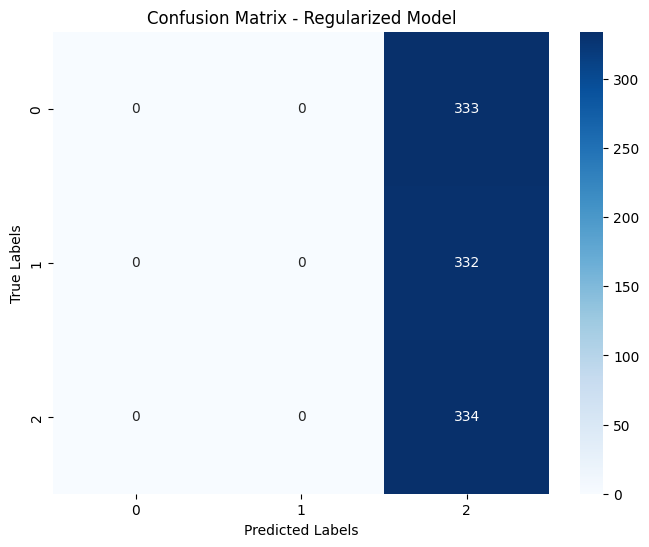

In [126]:


# making a prediction on the test data using the regularized model
r_pred_prob = model.predict(X_test)  # Predict probabilities
r_pred_labels = np.argmax(r_pred_prob, axis=1)  # Get the predicted class labels from the probabilities

# getting the true labels of the test data and comparing them with the predicted labels
# Ensure y_test is the correct ground truth labels for the test set
r_true_labels = y_test  # If y_test is one-hot encoded, we need to get the class index

# Confusion matrix
conf_matrix = confusion_matrix(r_true_labels, r_pred_labels)
print("\nConfusion Matrix:\n", conf_matrix)

# Getting the class names
class_names = y_test.columns if hasattr(y_test, 'columns') else range(len(np.unique(r_true_labels)))  
# If y_test is in one-hot format, it will have 'columns' attribute, otherwise we use range for label indices

# Classification report
print("\nClassification Report:\n", classification_report(r_true_labels, r_pred_labels, target_names=[str(i) for i in class_names]))

# Calculating the performance metrics of the model using the true and predicted labels
accuracy = accuracy_score(r_true_labels, r_pred_labels)
precision = precision_score(r_true_labels, r_pred_labels, average='weighted')  
recall = recall_score(r_true_labels, r_pred_labels, average='weighted')  
f1 = f1_score(r_true_labels, r_pred_labels, average='weighted') 

print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in class_names], 
            yticklabels=[str(i) for i in class_names])
plt.title('Confusion Matrix - Regularized Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [128]:
import joblib

model.save('../model/edupred.keras')
